## Background information
Oil and gas reservoirs lie deep beneath the Earth's surface. Geologists and engineers cannot examine the rock formations in situ, so tools called sondes go there for them. Specialists lower these tools into a wellbore and obtain measurements of subsurface properties. The data are displayed as a series of measurements covering a depth range in a display called a well log. Often, several tools are run simultaneously as a logging string, and the combination of results is more informative than each individual measurement (https://www.slb.com/resource-library/oilfield-review/defining-series/defining-logging).

## Objective
Train a Machine Learning model to predict lithology using log measurements from geothermal wells.

## Data Source
https://gdr.openei.org/submissions/1111 

In [1]:
import graphviz
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn import tree
from sklearn.datasets import *

In [2]:
from platform import python_version

print('The Python version is {}.' .format(python_version()))
print('The scikit-learn version is {}.'.format(sklearn.__version__))

The Python version is 3.8.2.
The scikit-learn version is 0.23.2.


We'll work with the Well_Data.csv. It has numerical value columns:

DENS: Density log
GR: Gamma ray log
SP: Spontaneous log
DEEP_RES: Deep Resistivity log
CAL: Caliper log

In [2]:
df = pd.read_csv('Well_Data.csv')
df.head()

,DENS,GR,SP,DEEP_RES,CAL,Lithology
0,2.5552,159.1349,82.500,1950.000,8.8111,Granitiod
1,2.0330,152.9230,-3.054,4.121,10.2130,Granitiod
2,2.5360,148.3970,3.369,2.099,14.7900,Granitiod
3,2.2640,154.8470,-2.059,1.265,12.4940,Granitiod
4,3.9170,72.0860,3.696,5.645,10.2000,Granitiod


In [3]:
df.describe()

,DENS,GR,SP,DEEP_RES,CAL
count,28584.000000,30399.000000,30410.000000,30410.000000,30410.000000
mean,2.642602,142.226313,19.129150,173.825669,10.136536
std,0.460718,54.432473,48.371447,382.208613,3.122901
min,1.656000,20.493500,-181.250000,0.272000,3.237500
25%,2.376000,99.365000,-0.565000,2.410000,8.883500
50%,2.556150,144.720000,3.194700,7.981850,10.186400
75%,2.660000,171.758600,47.500000,93.990850,12.463000
max,4.628800,641.089700,172.656300,1986.700000,16.580300


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30410 entries, 0 to 30409
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   DENS       28584 non-null  float64
 1   GR         30399 non-null  float64
 2   SP         30410 non-null  float64
 3   DEEP_RES   30410 non-null  float64
 4   CAL        30410 non-null  float64
 5   Lithology  30410 non-null  object 
dtypes: float64(5), object(1)
memory usage: 1.4+ MB


## Clean Data
Delete rows with null value

In [5]:
df.isnull().sum()

DENS         1826
GR             11
SP              0
DEEP_RES        0
CAL             0
Lithology       0
dtype: int64

In [6]:
df.dropna(inplace=True)
print(df.info())
print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28573 entries, 0 to 30409
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   DENS       28573 non-null  float64
 1   GR         28573 non-null  float64
 2   SP         28573 non-null  float64
 3   DEEP_RES   28573 non-null  float64
 4   CAL        28573 non-null  float64
 5   Lithology  28573 non-null  object 
dtypes: float64(5), object(1)
memory usage: 1.5+ MB
None
DENS         0
GR           0
SP           0
DEEP_RES     0
CAL          0
Lithology    0
dtype: int64


## Data Visualization

In [9]:
df.columns

Index(['DENS', 'GR', 'SP', 'DEEP_RES', 'CAL', 'Lithology'], dtype='object')

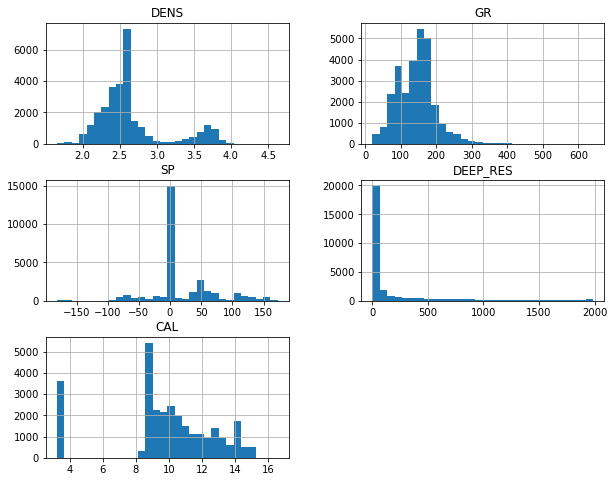

In [10]:
df.hist(bins=30, figsize=(10, 8))
plt.grid(which='both')
plt.show()

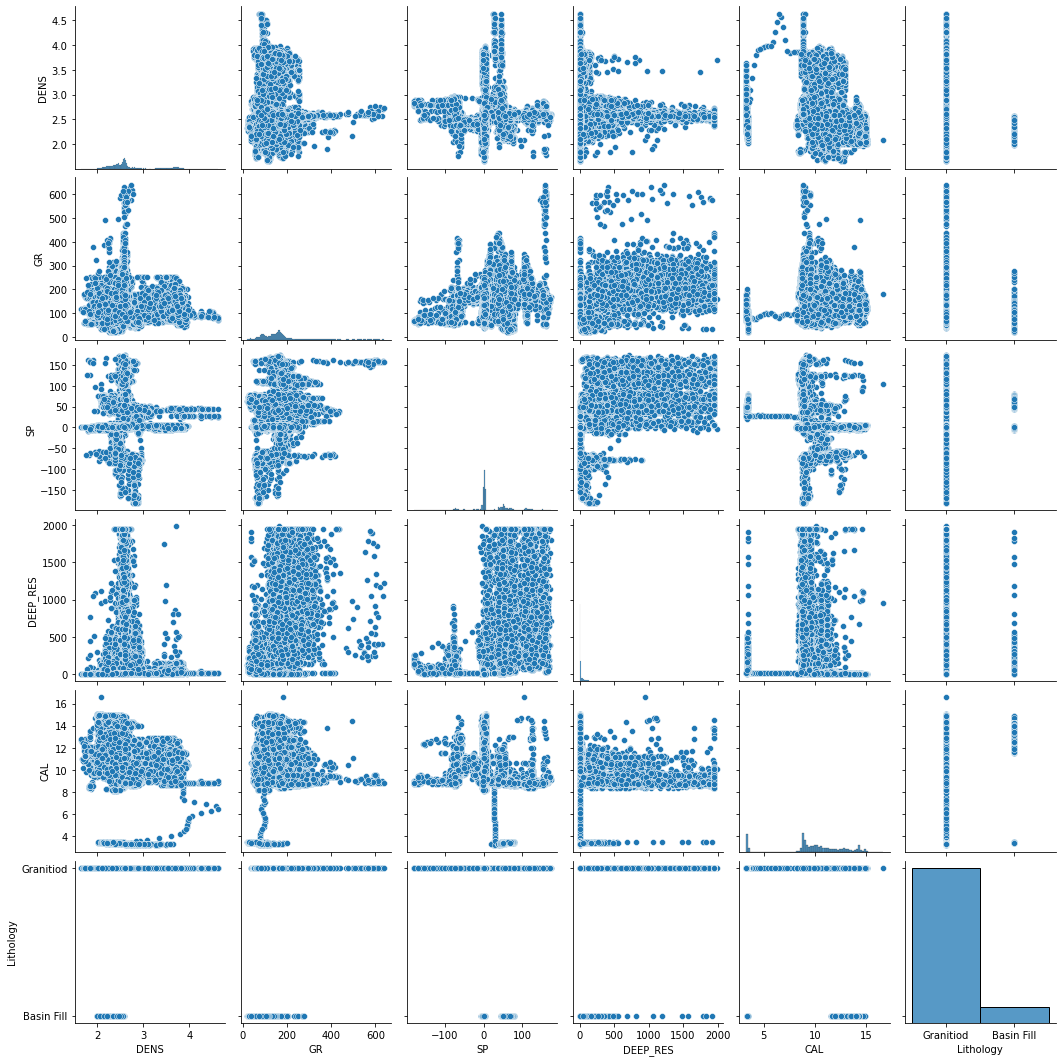

In [11]:
##Bivariate Distribution
sns.pairplot(df,vars=df.columns,markers='o')

<AxesSubplot:>

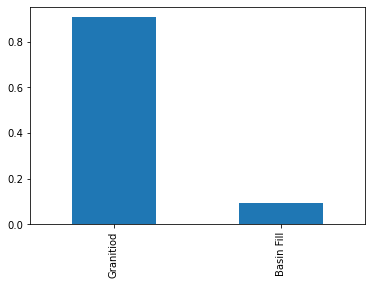

In [11]:
df['Lithology'].value_counts(normalize=True).plot(kind='bar')

There is class imbalance between response feature Granitiod and Basin Fill

In [12]:
print(df['Lithology'].value_counts())
print(df['Lithology'].value_counts(normalize=True))

Granitiod     25923
Basin Fill     2650
Name: Lithology, dtype: int64
Granitiod     0.907255
Basin Fill    0.092745
Name: Lithology, dtype: float64


In [11]:
x = df.drop('Lithology',axis=1) ## Lithology is the target values
y = df['Lithology']

### Address data imbalance by oversample Basin Fill class label and undersample Granitiod class label

In [81]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE

#### Oversample Basin Fill class label

In [233]:
sm = SMOTE(sampling_strategy=0.2, random_state=42)
x_res, y_res = sm.fit_resample(x, y)
print(y_res.value_counts())

Granitiod     25923
Basin Fill     5184
Name: Lithology, dtype: int64


### Standardize
Standardize features by removing the mean and scaling to unit variance

In [16]:
from sklearn.preprocessing import StandardScaler

In [239]:
scaler = StandardScaler()
scaler.fit(x_res)   
scaled_features = scaler.transform(x_res)

In [240]:
x_std = pd.DataFrame(scaled_features,columns=x_res.columns)
x_std.head()

,DENS,GR,SP,DEEP_RES,CAL
0,-0.119091,0.362230,1.247808,4.696386,-0.250820
1,-1.262741,0.251554,-0.512900,-0.452619,0.169679
2,-0.161140,0.170915,-0.380714,-0.457969,1.542547
3,-0.756837,0.285834,-0.492422,-0.460176,0.853863
4,2.863335,-1.188703,-0.373984,-0.448586,0.165779


In [241]:
x_std.describe()

,DENS,GR,SP,DEEP_RES,CAL
count,3.110700e+04,3.110700e+04,3.110700e+04,3.110700e+04,3.110700e+04
mean,1.608069e-16,-2.485198e-16,-5.482054e-17,2.923762e-17,-4.678019e-16
std,1.000016e+00,1.000016e+00,1.000016e+00,1.000016e+00,1.000016e+00
min,-2.088395e+00,-2.107916e+00,-4.180187e+00,-4.628034e-01,-1.922618e+00
25%,-6.098619e-01,-8.065591e-01,-4.529396e-01,-4.559342e-01,-2.508203e-01
50%,-1.699006e-01,4.170774e-02,-3.741076e-01,-4.336751e-01,1.037798e-01
75%,6.366952e-02,5.643458e-01,6.175433e-01,-1.840843e-01,7.056883e-01
max,4.422221e+00,8.949124e+00,3.103232e+00,4.793498e+00,2.079546e+00


In [242]:
x.describe()

,DENS,GR,SP,DEEP_RES,CAL
count,28573.000000,28573.000000,28573.000000,28573.000000,28573.000000
mean,2.642713,144.029034,20.311293,184.931278,9.897897
std,0.460770,54.915536,49.665243,391.704903,3.054125
min,1.656000,20.493500,-181.250000,0.272000,3.237500
25%,2.376000,101.867900,-0.279000,2.936000,8.859300
50%,2.556300,147.685000,3.456000,10.416100,10.000000
75%,2.660000,172.663200,49.375000,111.722000,11.950000
max,4.628800,641.089700,172.656300,1986.700000,16.580300


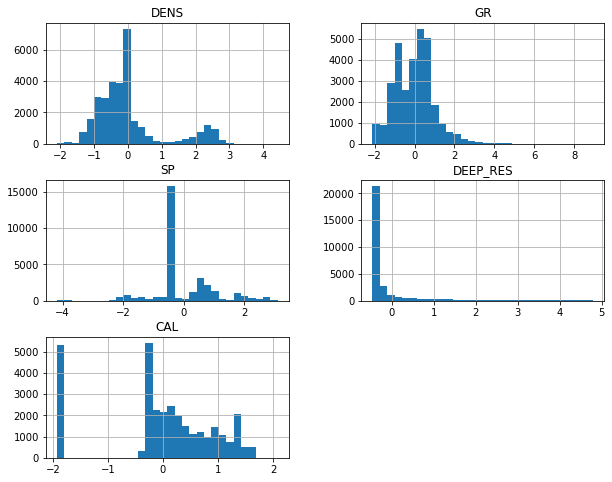

In [243]:
x_std.hist(bins=30, figsize=(10, 8))
plt.grid(which='both')
plt.show()

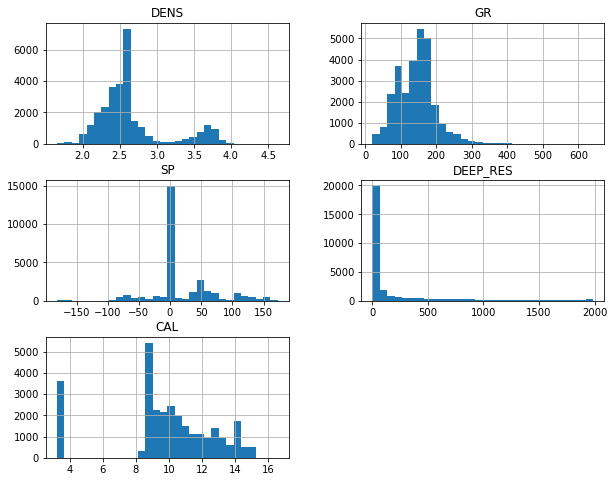

In [244]:
x.hist(bins=30, figsize=(10, 8))
plt.grid(which='both')
plt.show()

### Split training and testing data

In [246]:
from sklearn.model_selection import train_test_split

In [247]:
x_train, x_test, y_train, y_test = train_test_split(x_std, y_res, test_size=0.20, random_state=42, stratify=y_res)

In [248]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24885 entries, 29737 to 21764
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   DENS      24885 non-null  float64
 1   GR        24885 non-null  float64
 2   SP        24885 non-null  float64
 3   DEEP_RES  24885 non-null  float64
 4   CAL       24885 non-null  float64
dtypes: float64(5)
memory usage: 1.1 MB


In [249]:
y_train.value_counts()

Granitiod     20738
Basin Fill     4147
Name: Lithology, dtype: int64

In [250]:
x_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6222 entries, 30816 to 7784
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   DENS      6222 non-null   float64
 1   GR        6222 non-null   float64
 2   SP        6222 non-null   float64
 3   DEEP_RES  6222 non-null   float64
 4   CAL       6222 non-null   float64
dtypes: float64(5)
memory usage: 291.7 KB


In [251]:
y_test.value_counts()

Granitiod     5185
Basin Fill    1037
Name: Lithology, dtype: int64

## Data Training and Testing

### Decision Tree

In [31]:
from sklearn import tree
from sklearn.datasets import *
from sklearn.metrics import classification_report,confusion_matrix

In [252]:
### Training decision tree model with tree depth ranging from 1 to 25

DT_error_rate = []
depth = []

idepth = 1
while idepth < 26:
    my_tree = tree.DecisionTreeClassifier(criterion = "entropy", max_depth = idepth, min_samples_leaf = 4, random_state=42)
    my_tree = my_tree.fit(x_train, y_train)
    #trees.append(my_tree)
    y_DT = my_tree.predict(x_test)
    DT_error_rate.append(np.mean(y_DT != y_test))
    depth.append(idepth)
    
    idepth+=1

Text(0, 0.5, 'Error Rate')

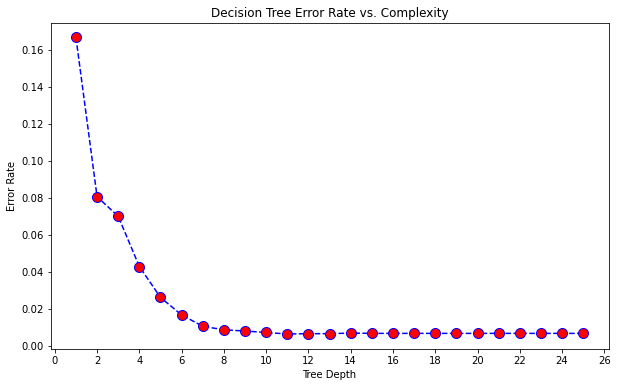

In [253]:
plt.figure(figsize=(10,6))
plt.plot(depth,DT_error_rate,color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=10)
plt.xticks(np.arange(0, 27, step=2))
plt.title('Decision Tree Error Rate vs. Complexity')
plt.xlabel('Tree Depth')
plt.ylabel('Error Rate')

In [254]:
### Training decision tree model with tree depth ranging from 10 to 25

DT_error_rate = []
depth = []

idepth = 10
while idepth < 26:
    my_tree = tree.DecisionTreeClassifier(criterion = "entropy", max_depth = idepth, min_samples_leaf = 4, random_state=42)
    my_tree = my_tree.fit(x_train, y_train)
    #trees.append(my_tree)
    y_DT = my_tree.predict(x_test)
    DT_error_rate.append(np.mean(y_DT != y_test))
    depth.append(idepth)
    
    idepth+=1

Text(0, 0.5, 'Error Rate')

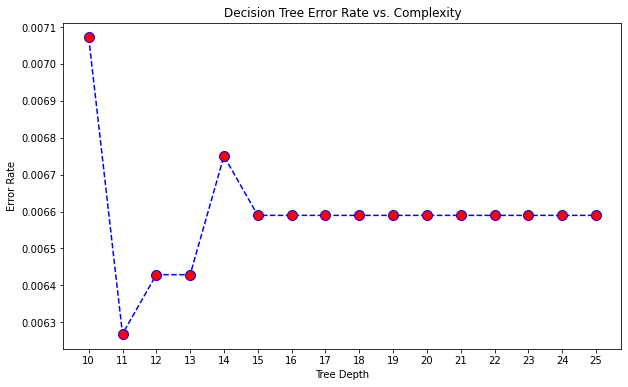

In [255]:
plt.figure(figsize=(10,6))
plt.plot(depth,DT_error_rate,color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=10)
plt.xticks(np.arange(10, 26, step=1))
plt.title('Decision Tree Error Rate vs. Complexity')
plt.xlabel('Tree Depth')
plt.ylabel('Error Rate')

In [256]:
my_tree = tree.DecisionTreeClassifier(criterion = "entropy", max_depth = 11, min_samples_leaf = 4, random_state=42)
my_tree_fit = my_tree.fit(x_train, y_train)
y_dtc = my_tree_fit.predict(x_test)

In [259]:
print('max_depth = 11, min_samples_leaf = 4, Training Sample = 0.8')
print('\n')
print('Mean Accuracy')
print(my_tree.score(x_test, y_test))
print('\n')
print(confusion_matrix(y_test,y_dtc))  ## TN: C00, FN: C10, TP: C11, FP: C01
print('\n')
print(classification_report(y_test,y_dtc))

max_depth = 11, min_samples_leaf = 4, Training Sample = 0.8


Accuracy
0.993731918997107


[[1020   17]
 [  22 5163]]


              precision    recall  f1-score   support

  Basin Fill       0.98      0.98      0.98      1037
   Granitiod       1.00      1.00      1.00      5185

    accuracy                           0.99      6222
   macro avg       0.99      0.99      0.99      6222
weighted avg       0.99      0.99      0.99      6222



#### Cross Validation

In [119]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

In [260]:
cv_results = cross_validate(my_tree_fit, x_train, y_train, cv=5, scoring=['accuracy', 'precision_macro', 'precision_weighted', 'f1_macro', 'f1_weighted'])
cv_results

{'fit_time': array([0.08705616, 0.07130599, 0.071275  , 0.06390381, 0.07383776]),
 'score_time': array([0.1381321 , 0.14019012, 0.13716078, 0.13765621, 0.14129043]),
 'test_accuracy': array([0.99236488, 0.98693992, 0.99296765, 0.99437412, 0.99035564]),
 'test_precision_macro': array([0.9818508 , 0.97542048, 0.98182924, 0.98940695, 0.98308227]),
 'test_precision_weighted': array([0.99249322, 0.98697476, 0.99313802, 0.99438011, 0.99034688]),
 'test_f1_macro': array([0.98639413, 0.97655962, 0.98748607, 0.9898783 , 0.98261498]),
 'test_f1_weighted': array([0.9924011 , 0.98695559, 0.99300925, 0.99437683, 0.99035097])}

#### Visualize Tree

In [261]:
x_features = x.columns.tolist()
y_target = y.unique().tolist()

In [262]:
text_representation = tree.export_text(my_tree_fit, feature_names = x_features)
print(text_representation)

|--- GR <= -0.61
|   |--- DENS <= -0.15
|   |   |--- DEEP_RES <= -0.40
|   |   |   |--- DEEP_RES <= -0.46
|   |   |   |   |--- SP <= -0.43
|   |   |   |   |   |--- class: Basin Fill
|   |   |   |   |--- SP >  -0.43
|   |   |   |   |   |--- CAL <= 1.26
|   |   |   |   |   |   |--- SP <= -0.41
|   |   |   |   |   |   |   |--- GR <= -0.68
|   |   |   |   |   |   |   |   |--- CAL <= 0.97
|   |   |   |   |   |   |   |   |   |--- class: Basin Fill
|   |   |   |   |   |   |   |   |--- CAL >  0.97
|   |   |   |   |   |   |   |   |   |--- SP <= -0.42
|   |   |   |   |   |   |   |   |   |   |--- class: Basin Fill
|   |   |   |   |   |   |   |   |   |--- SP >  -0.42
|   |   |   |   |   |   |   |   |   |   |--- class: Granitiod
|   |   |   |   |   |   |   |--- GR >  -0.68
|   |   |   |   |   |   |   |   |--- class: Granitiod
|   |   |   |   |   |   |--- SP >  -0.41
|   |   |   |   |   |   |   |--- class: Basin Fill
|   |   |   |   |   |--- CAL >  1.26
|   |   |   |   |   |   |--- CAL <= 1.34
|   |

In [127]:
fig = plt.figure(figsize = [100,80], dpi = 150)
ax = tree.plot_tree(my_tree_fit, feature_names = x_features, class_names = y_target)
plt.show()

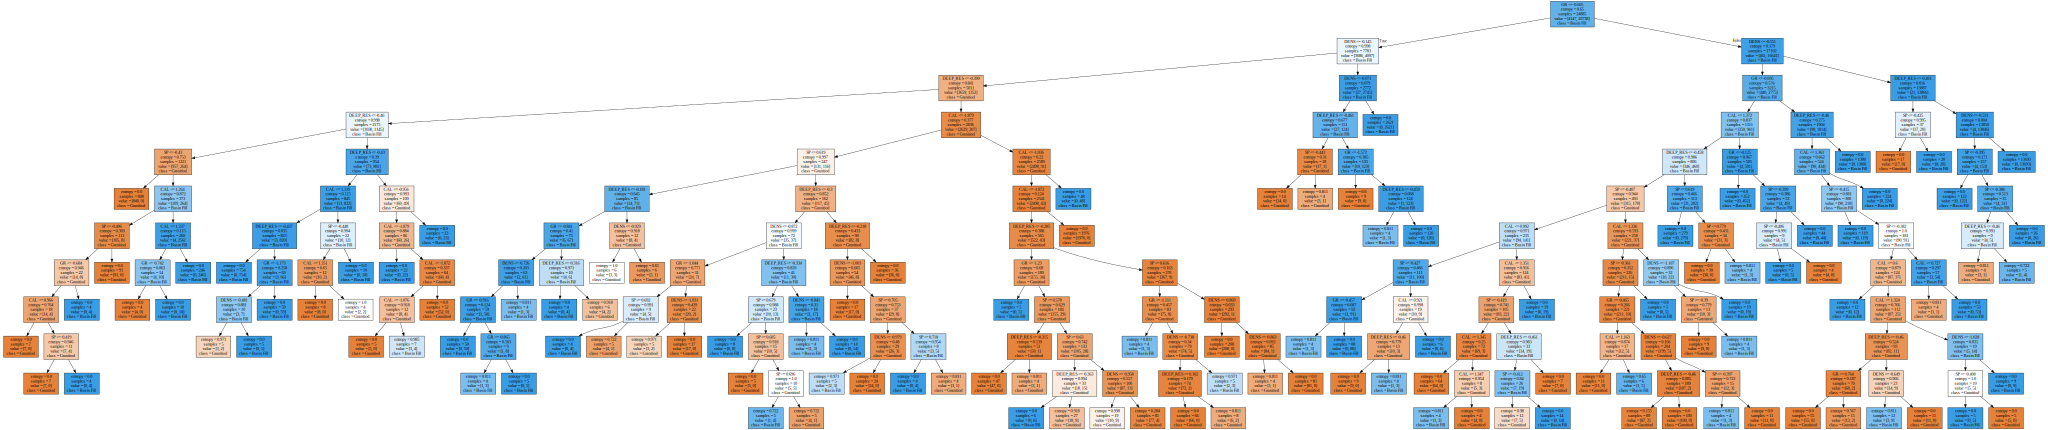

In [263]:
dot_data = tree.export_graphviz(my_tree_fit, out_file=None, feature_names = x_features, class_names = y_target, filled=True)
graph = graphviz.Source(dot_data, format="png") 
graph

In [264]:
graph.render("decision_tree_graphivz")

'decision_tree_graphivz.png'

### Random Forest

In [279]:
from sklearn.ensemble import RandomForestClassifier

In [265]:
### Training Random Forest model with tree depth ranging from 2 to 25

RF_error_rate = []
depth = []

idepth = 2
while idepth < 26:
    my_rf = RandomForestClassifier(criterion = "entropy", max_depth=idepth, min_samples_leaf = 4, random_state=42)
    my_rf_fit = my_rf.fit(x_train, y_train)
    #trees.append(my_tree)
    y_rfc = my_rf_fit.predict(x_test)
    RF_error_rate.append(np.mean(y_rfc != y_test))
    depth.append(idepth)
    
    idepth+=1

Text(0, 0.5, 'Error Rate')

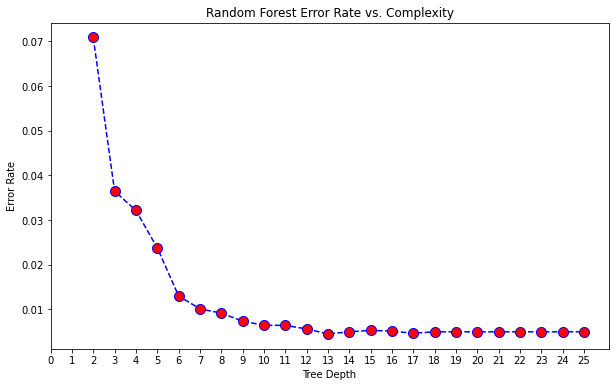

In [266]:
plt.figure(figsize=(10,6))
plt.plot(depth,RF_error_rate, color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=10)
plt.xticks(np.arange(0, 26, step=1))
plt.title('Random Forest Error Rate vs. Complexity')
plt.xlabel('Tree Depth')
plt.ylabel('Error Rate')

In [269]:
### Training decision tree model with tree depth ranging from 12 to 25

RF_error_rate = []
depth = []

idepth = 12
while idepth < 26:
    my_rf = RandomForestClassifier(criterion = "entropy", max_depth=idepth, min_samples_leaf = 4, random_state=42)
    my_rf_fit = my_rf.fit(x_train, y_train)
    y_rfc = my_rf_fit.predict(x_test)
    RF_error_rate.append(np.mean(y_rfc != y_test))
    depth.append(idepth)
    
    idepth+=1

Text(0, 0.5, 'Error Rate')

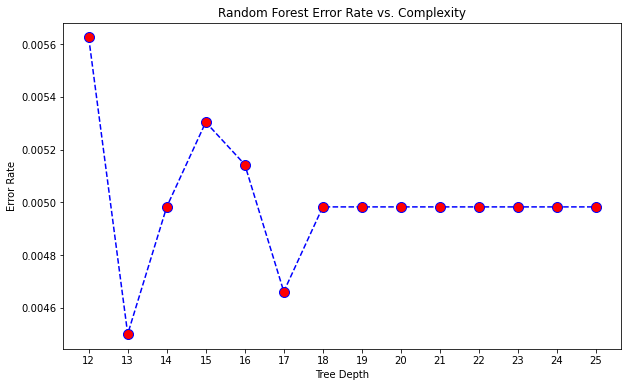

In [270]:
plt.figure(figsize=(10,6))
plt.plot(depth,RF_error_rate, color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=10)
plt.xticks(np.arange(12, 26, step=1))
plt.title('Random Forest Error Rate vs. Complexity')
plt.xlabel('Tree Depth')
plt.ylabel('Error Rate')

In [271]:
my_rf = RandomForestClassifier(criterion = "entropy", max_depth=13, min_samples_leaf = 4, random_state=42)
my_rf_fit = my_rf.fit(x_train, y_train)
y_rfc = my_rf_fit.predict(x_test)

In [272]:
print('max_depth = 15, min_samples_leaf = 4, Training Sample = 0.8')
print('\n')
print('Mean Accuracy')
print(my_rf.score(x_test, y_test))
print('\n')
print(confusion_matrix(y_test,y_rfc))  ## TN: C00, FN: C10, TP: C11, FP: C01
print('\n')
print(classification_report(y_test,y_rfc))

max_depth = 15, min_samples_leaf = 4, Training Sample = 0.8


Accuracy
0.9954998392799743


[[1031    6]
 [  22 5163]]


              precision    recall  f1-score   support

  Basin Fill       0.98      0.99      0.99      1037
   Granitiod       1.00      1.00      1.00      5185

    accuracy                           1.00      6222
   macro avg       0.99      0.99      0.99      6222
weighted avg       1.00      1.00      1.00      6222



### KNN

In [41]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report,confusion_matrix

In [274]:
### Training k-nearest neighbor model with number of neighbor ranging from 3 to 20

k_error_rate = []
k_number = []
k = 3
while k < 21:
    
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(x_train,y_train)
    y_knn = knn.predict(x_test)
    k_error_rate.append(np.mean(y_knn != y_test))
    k_number.append(k)
    k += 1

Text(0, 0.5, 'Error Rate')

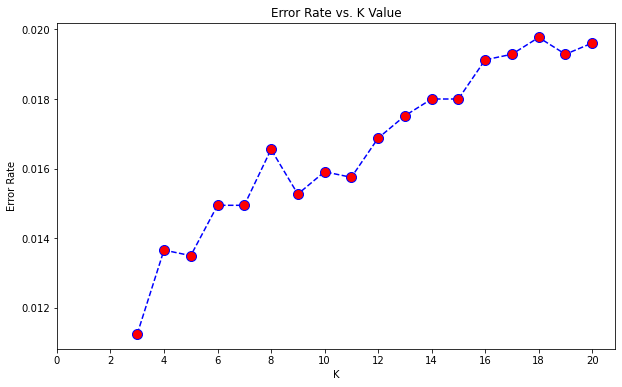

In [275]:
plt.figure(figsize=(10,6))
plt.plot(k_number,k_error_rate,color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=10)
plt.xticks(np.arange(0, 21, step=2))
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')

In [277]:
knn_3 = KNeighborsClassifier(n_neighbors=3)
knn_3.fit(x_train,y_train)
y_knn_3 = knn_3.predict(x_test)

In [278]:
print('Training Sample=0.8, K=3')
print('Mean Accuracy')
print(knn_3.score(x_test, y_test))
print('\n')
print(confusion_matrix(y_test,y_knn_3))
print('\n')
print(classification_report(y_test,y_knn_3))

Training Sample=0.8, K=3
Mean Accuracy
0.9887495981999357


[[1009   28]
 [  42 5143]]


              precision    recall  f1-score   support

  Basin Fill       0.96      0.97      0.97      1037
   Granitiod       0.99      0.99      0.99      5185

    accuracy                           0.99      6222
   macro avg       0.98      0.98      0.98      6222
weighted avg       0.99      0.99      0.99      6222

